# Predicting the Survival of Titanic Passengers

# Understanding Problem Statement

The Titanic dataset has (891, 12) attributes. It provides information on the fate of passengers on the Titanic, summarized according to economic status (class), sex, age and survival.

11 features + the target variable (survived). What features could contribute to a high survival rate of the passengers.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE,ADASYN,SVMSMOTE
from collections import Counter
from boruta import BorutaPy
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from skopt import gbrt_minimize, gp_minimize 
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

warnings.filterwarnings('ignore')

In [2]:
# Read the given train data
test_df = pd.read_csv("D:/Desktop/test.csv")
train_df = pd.read_csv("D:/Desktop/train.csv")
train_df.head(100)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0,3,"Shorney, Mr. Charles Joseph",male,NaN,0,0,374910,8.0500,NaN,S
96,97,0,1,"Goldschmidt, Mr. George B",male,71.0,0,0,PC 17754,34.6542,A5,C
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,C
98,99,1,2,"Doling, Mrs. John T (Ada Julia Bone)",female,34.0,0,1,231919,23.0000,NaN,S


In [3]:
train_df.shape

(891, 12)

In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# EXPLORATORY  DATA  ANALYSIS

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# List value_counts on all columns
for col in train_df.columns:
    print('-' * 40 + col + '-' * 40 , end=' - ')
    display(train_df[col].value_counts().head(100))

----------------------------------------PassengerId---------------------------------------- - 

1      1
599    1
588    1
589    1
590    1
      ..
625    1
626    1
628    1
640    1
629    1
Name: PassengerId, Length: 100, dtype: int64

----------------------------------------Survived---------------------------------------- - 

0    549
1    342
Name: Survived, dtype: int64

----------------------------------------Pclass---------------------------------------- - 

3    491
1    216
2    184
Name: Pclass, dtype: int64

----------------------------------------Name---------------------------------------- - 

Bystrom, Mrs. (Karolina)                    1
Holverson, Mr. Alexander Oskar              1
Taussig, Mrs. Emil (Tillie Mandelbaum)      1
Vander Planke, Mr. Leo Edmondus             1
Jansson, Mr. Carl Olof                      1
                                           ..
Abelson, Mrs. Samuel (Hannah Wizosky)       1
Petroff, Mr. Pastcho ("Pentcho")            1
Kelly, Miss. Anna Katherine "Annie Kate"    1
Yasbeck, Mrs. Antoni (Selini Alexander)     1
Cohen, Mr. Gurshon "Gus"                    1
Name: Name, Length: 100, dtype: int64

----------------------------------------Sex---------------------------------------- - 

male      577
female    314
Name: Sex, dtype: int64

----------------------------------------Age---------------------------------------- - 

24.00    30
22.00    27
18.00    26
28.00    25
19.00    25
         ..
55.50     1
74.00     1
0.92      1
70.50     1
12.00     1
Name: Age, Length: 88, dtype: int64

----------------------------------------SibSp---------------------------------------- - 

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

----------------------------------------Parch---------------------------------------- - 

0    678
1    118
2     80
3      5
5      5
4      4
6      1
Name: Parch, dtype: int64

----------------------------------------Ticket---------------------------------------- - 

CA. 2343     7
347082       7
1601         7
3101295      6
CA 2144      6
            ..
250649       2
19928        2
376564       2
PC 17558     2
A/5. 3336    2
Name: Ticket, Length: 100, dtype: int64

----------------------------------------Fare---------------------------------------- - 

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
20.5750     2
7.7375      2
9.2250      2
55.9000     2
20.2500     2
Name: Fare, Length: 100, dtype: int64

----------------------------------------Cabin---------------------------------------- - 

C23 C25 C27    4
B96 B98        4
G6             4
D              3
C22 C26        3
              ..
A7             1
C110           1
E17            1
C70            1
B3             1
Name: Cabin, Length: 100, dtype: int64

----------------------------------------Embarked---------------------------------------- - 

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [7]:
# Find the Number of counts of Target
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

# Analyse each column individully and visualize accordingly

In [8]:
round(((train_df[(train_df.Survived ==1)].SibSp != 0).sum()/342)*100,2)

# Out of 342 people who survived, almost 39% had siblings or their spouse on board

38.6

In [9]:
round(((train_df[(train_df.Survived ==0)].SibSp != 0).sum()/549)*100,2)

# Out of 549 people who died, around 28% had siblings or their spouse on board

27.5

In [10]:
round(((train_df[(train_df.Survived ==1)].Parch != 0).sum()/342)*100,2)

# Out of 342 people who survived, 32% had their parents or children on board

31.87

In [11]:
round(((train_df[(train_df.Survived ==0)].Parch != 0).sum()/549)*100,2)

# Out of 549 people who died, 19% had their parents or children on board

18.94

<AxesSubplot:>

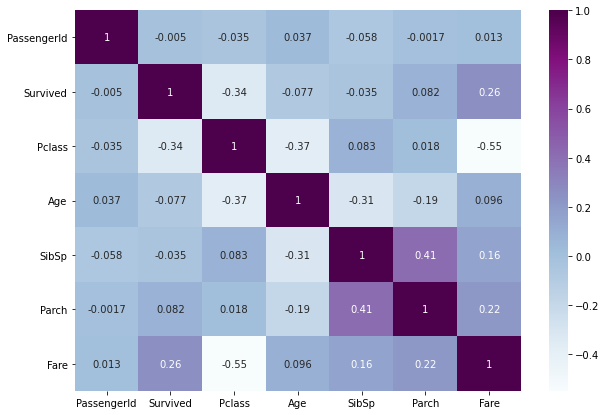

In [12]:
torr = train_df.corr()
plt.figure(figsize=(10,7))
sns.heatmap(torr, annot = True, cmap="BuPu")

' When looking from class perspective, those who lost their lives belonged\nto class 3 and naturally those got out alive belonged to class 1'

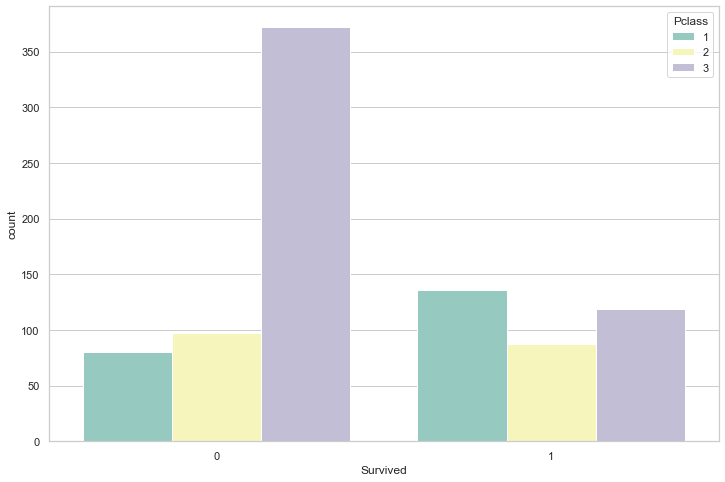

In [13]:
plt.figure(figsize=(12,8))
sns.set_theme(style='whitegrid')
sns.countplot(x=train_df.Survived, hue=train_df.Pclass, palette='Set3')

''' When looking from class perspective, those who lost their lives belonged
to class 3 and naturally those got out alive belonged to class 1'''


'  Majority who died were males  '

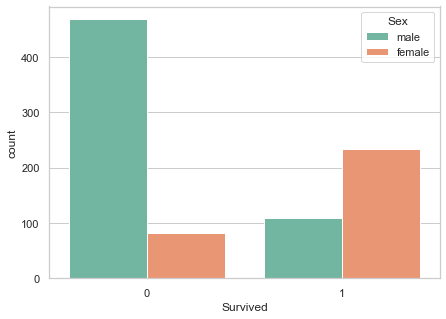

In [14]:
plt.figure(figsize=(7,5))
sns.set_theme(style='whitegrid')
sns.countplot(x=train_df.Survived, hue=train_df.Sex, palette='Set2')

'''  Majority who died were males  '''

'There is no significant differences between ages of deceased and alive  '

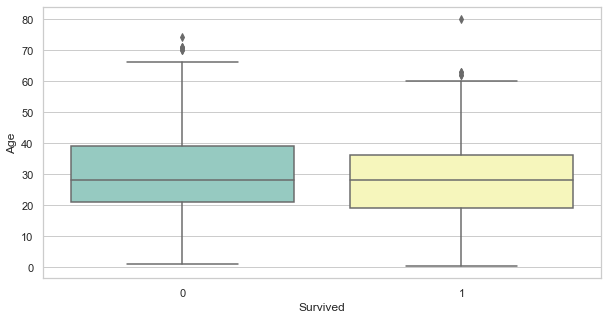

In [15]:
plt.figure(figsize=(10,5))
sns.set_theme(style='whitegrid')
sns.boxplot(x=train_df.Survived, y = train_df.Age, palette='Set3')

'''There is no significant differences between ages of deceased and alive  '''

'The plot indicates that the fare amount and corrsponding casualities\nare inversly proportional but the dataset mostly contains fare in the range 0-100 '

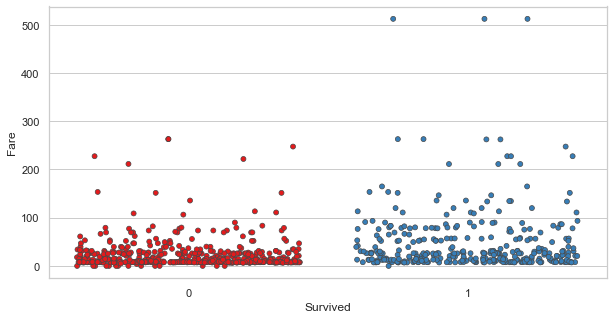

In [16]:
plt.figure(figsize=(10,5))
sns.set_theme(style='whitegrid')
sns.stripplot(x=train_df.Survived, y = train_df.Fare, palette='Set1',linewidth=0.7, jitter=0.4)

'''The plot indicates that the fare amount and corrsponding casualities
are inversly proportional but the dataset mostly contains fare in the range 0-100 '''


<AxesSubplot:xlabel='Survived', ylabel='count'>

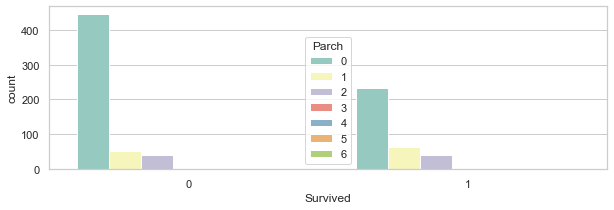

In [17]:
plt.figure(figsize=(10,3))
sns.set_theme(style='whitegrid')
sns.countplot(x=train_df.Survived, hue=train_df.Parch, palette='Set3')

<AxesSubplot:xlabel='Survived', ylabel='count'>

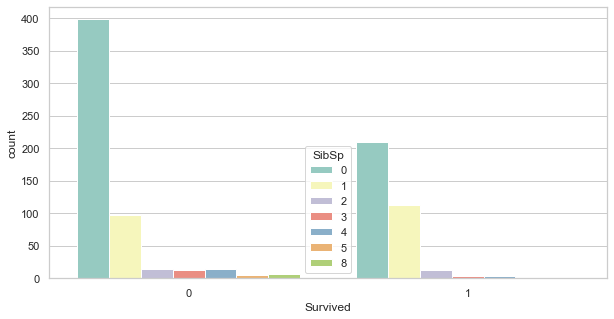

In [18]:
plt.figure(figsize=(10,5))
sns.set_theme(style='whitegrid')
sns.countplot(x=train_df.Survived, hue=train_df.SibSp, palette='Set3')

<AxesSubplot:xlabel='Survived', ylabel='count'>

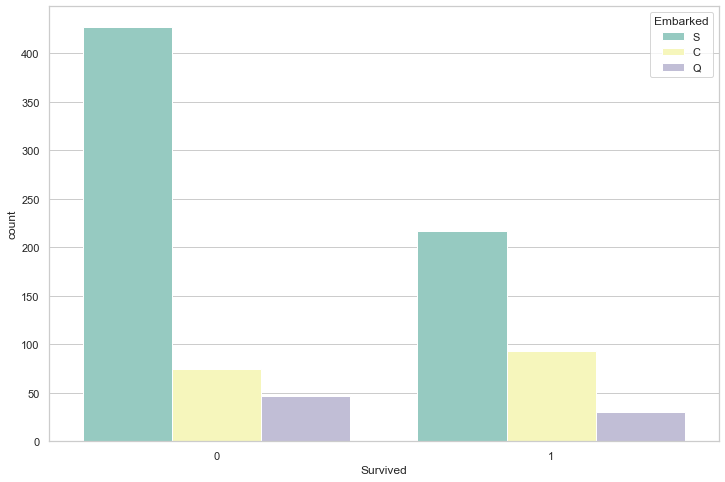

In [19]:
plt.figure(figsize=(12,8))
sns.set_theme(style='whitegrid')
sns.countplot(x=train_df.Survived, hue=train_df.Embarked, palette='Set3')

# People aboard were mostly from "s" category and also the ones who lost most lives, which is intuitive!

In [20]:
train_df.Pclass.isnull().sum()  #no missing value

0

In [21]:
train_df.Pclass.value_counts()  # Majority are from 3rd class

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [22]:
train_df.groupby('Pclass').median()

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,472.0,1.0,37.0,0.0,0.0,60.2875
2,435.5,0.0,29.0,0.0,0.0,14.2500
3,432.0,0.0,24.0,0.0,0.0,8.0500


<AxesSubplot:xlabel='Pclass', ylabel='count'>

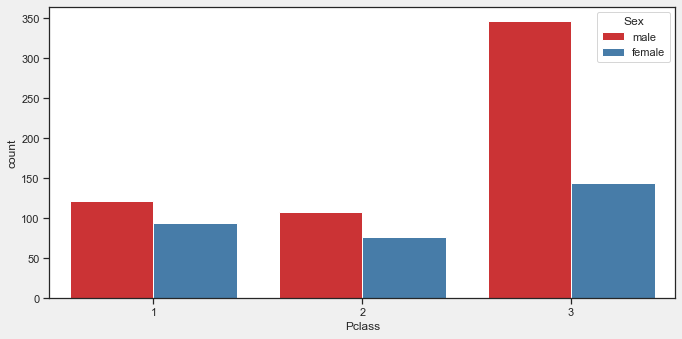

In [23]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,5))
sns.set_theme(style='ticks')
sns.countplot(x=train_df.Pclass, hue=train_df.Sex, palette='Set1' )

# Most people belonged to 3rd class with male as the clear majority

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

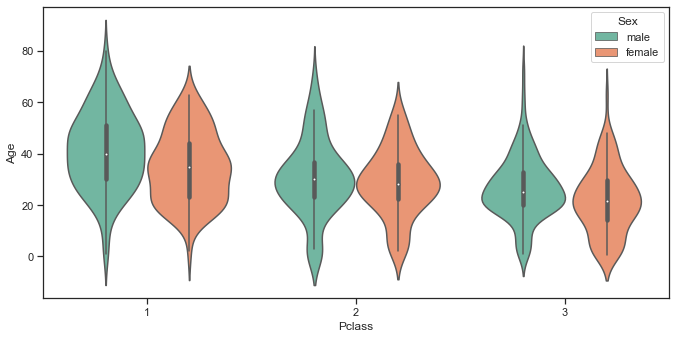

In [24]:
plt.figure(figsize=(10,5))
sns.set_theme(style='ticks')
sns.violinplot(x=train_df.Pclass, y = train_df.Age, palette='Set2', hue=train_df.Sex)

# We have people of all age group similarly distributed across three classes with elederly people more in class 1

<AxesSubplot:xlabel='Pclass', ylabel='count'>

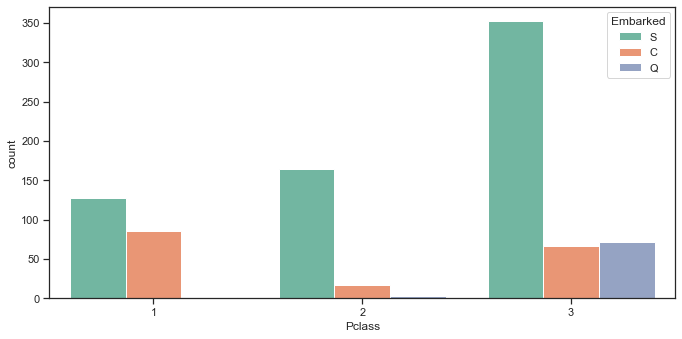

In [25]:
plt.figure(figsize=(10,5))
sns.set_theme(style='ticks')
sns.countplot(x=train_df.Pclass, hue=train_df.Embarked, palette='Set2')

# Southampton seems to be the most popular or the biggest yard according to the figure below

<AxesSubplot:ylabel='Density'>

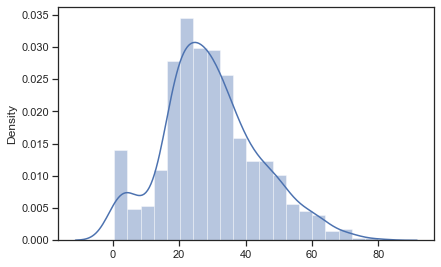

In [26]:
sns.distplot(x = train_df.Age)

# Data Preprocessing

# Missing Value In %

In [27]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

#cabinn column has more than 50% missing value wont be much helpulin prediction its better
#to remove it from dataframe.'''

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
PassengerId,0,0.0
Survived,0,0.0


In [28]:
train_df = train_df.drop(['PassengerId'], axis=1)

In [29]:
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [30]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [31]:
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [32]:
#Converting Features:


data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [33]:
#handling age column 
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)
train_df["Age"].isnull().sum()

0

In [34]:
#only 2 blanks are present can be filled by common_value
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [35]:
# Mapping

genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [36]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

# Creating Categories

In [37]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

# let's see how it's distributed train_df['Age'].value_counts()

In [38]:
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

In [39]:
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,2,1,0,0,0
1,1,1,1,5,1,0,3,1
2,1,3,1,3,0,0,0,0
3,1,1,1,5,1,0,3,0
4,0,3,0,5,0,0,1,0
5,0,3,0,4,0,0,1,2
6,0,1,0,6,0,0,3,0
7,0,3,0,0,3,1,2,0
8,1,3,1,3,0,2,1,0
9,1,2,1,1,1,0,2,1


In [40]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

In [41]:
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_Class
0,0,3,0,2,1,0,0,0,6
1,1,1,1,5,1,0,3,1,5
2,1,3,1,3,0,0,0,0,9
3,1,1,1,5,1,0,3,0,5
4,0,3,0,5,0,0,1,0,15
5,0,3,0,4,0,0,1,2,12
6,0,1,0,6,0,0,3,0,6
7,0,3,0,0,3,1,2,0,0
8,1,3,1,3,0,2,1,0,9
9,1,2,1,1,1,0,2,1,2


Building Machine Learning Models

In [52]:
# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [42]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()

Logistic Regression:

In [43]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg=LogisticRegression()
logreg.fit(X_train,Y_train)#Data and labels
Y_pred=logreg.predict(X_test)
acc_log=  round(logreg.score(X_train,Y_train)*100,2)
print('LogisticRegression',acc_log)#LogisticRegression 81.26
#Logistic Regression to see the contribution rate of each characteristic
coeff_df = pd.DataFrame(train_df.columns.delete(0))#delete(0) remove the Survived tag
coeff_df.columns=['Feature']#Custom column name
coeff_df['Correlation']=pd.Series(logreg.coef_[0])#Read coefficient
coeff_df.sort_values(by='Correlation',ascending=False)

LogisticRegression 80.58


,Feature,Correlation
1,Sex,2.578939
5,Fare,0.280452
6,Embarked,0.232312
7,Age_Class,-0.018372
4,Parch,-0.147533
2,Age,-0.183654
3,SibSp,-0.392304
0,Pclass,-0.748500


Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

Sex (male: 0 to female: 1) is the largest positive number, and an increase in sex (i.e. = 1 female) is most likely to increase the probability of Survived=1. The second largest positive number (in this case, should assignment be logical when discretizing?)

Pclass is the largest negative number. The larger pclass is, the less likely it is to survive = 1. Age*Class is the second largest negative number in the author's results. I don't know why there is a big difference in this place.

SVM:

In [44]:
from sklearn import svm
svc=svm.SVC()
svc.fit(X_train,Y_train)
Y_pred=svc.predict(X_test)
acc_svc=round(svc.score(X_train,Y_train)*100,2)
acc_svc

81.71

Linear SVC:

In [45]:
linear_svc = svm.LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

80.36

K Nearest Neighbor:

In [49]:
from sklearn import neighbors
knn=neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,Y_train)
Y_pred=knn.predict(X_test)
acc_knn=round(knn.score(X_train,Y_train)*100,2)
acc_knn

86.64

Stochastic Gradient Descent (SGD):

In [53]:
from sklearn.linear_model import SGDClassifier
sgd = linear_model.SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

79.8

Gaussian Naive Bayes:

In [54]:
from sklearn.naive_bayes import GaussianNB
gaussian =GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

78.68

Perceptro:

In [55]:
from sklearn import linear_model
perceptron = linear_model.Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

78.56

DecisionTree:

In [56]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

90.35

 RandomFores:

In [57]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

90.35

In [58]:
#Sort the performance of different algorithms
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,90.35
8,Decision Tree,90.35
1,KNN,86.64
0,Support Vector Machines,81.71
2,Logistic Regression,80.58
7,Linear SVC,80.36
6,Stochastic Gradient Decent,79.80
4,Naive Bayes,78.68
5,Perceptron,78.56






K-Fold Cross Validation:

In [59]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.74444444 0.83146067 0.71910112 0.84269663 0.87640449 0.85393258
 0.84269663 0.79775281 0.80898876 0.83146067]
Mean: 0.8148938826466917
Standard Deviation: 0.046765950259977256


Random Forest

In [60]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Sex,0.345
Fare,0.133
Age_Class,0.124
Pclass,0.098
SibSp,0.093
Age,0.086
Embarked,0.066
Parch,0.056


<AxesSubplot:xlabel='feature'>

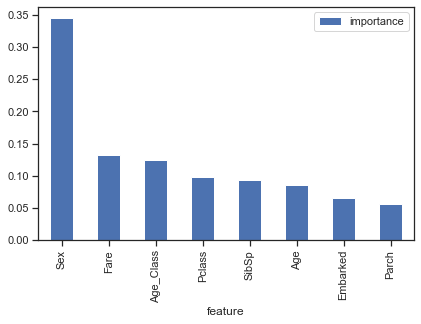

In [61]:
importances.plot.bar()

In [62]:
train_df  = train_df.drop("Parch", axis=1)
test_df  = test_df.drop("Parch", axis=1)

train_df  = train_df.drop("Embarked", axis=1)
test_df  = test_df.drop("Embarked", axis=1)



Training random forest again

In [63]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

90.35 %


In [64]:
print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 80.58 %


Hyperparameter Tuning:

In [66]:
param_grid = {'n_estimators' : np.random.randint(10,500,5), 
              'random_state' : np.random.randint(10,50000,5),
              'learning_rate' :[0.001, 0.01, 0.01, 0.1, 1, 10 ]
             }
param_grid

{'n_estimators': array([380,  24, 130,  71,  36]),
 'random_state': array([ 3462, 11413, 16541, 13223, 18976]),
 'learning_rate': [0.001, 0.01, 0.01, 0.1, 1, 10]}

Test new Parameters:


In [67]:
# Random Forest
random_forest = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)

random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 83.16 %


Further Evaluation:

Confusion Matrix

In [68]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=3)
confusion_matrix(Y_train, predictions)

array([[492,  57],
       [103, 239]], dtype=int64)

The first row is about the not-survived-predictions: 492 passengers were correctly classified as not survived (called true negatives) and 56 where wrongly classified as not survived (false positives).
The second row is about the survived-predictions: 103 passengers where wrongly classified as survived (false negatives) and 239 where correctly classified as survived (true positives).

Precision and Recall:

In [69]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:",recall_score(Y_train, predictions))

Precision: 0.8074324324324325
Recall: 0.6988304093567251


F-Score

In [70]:
from sklearn.metrics import f1_score
f1_score(Y_train, predictions)

0.749216300940439

Precision Recall Curve

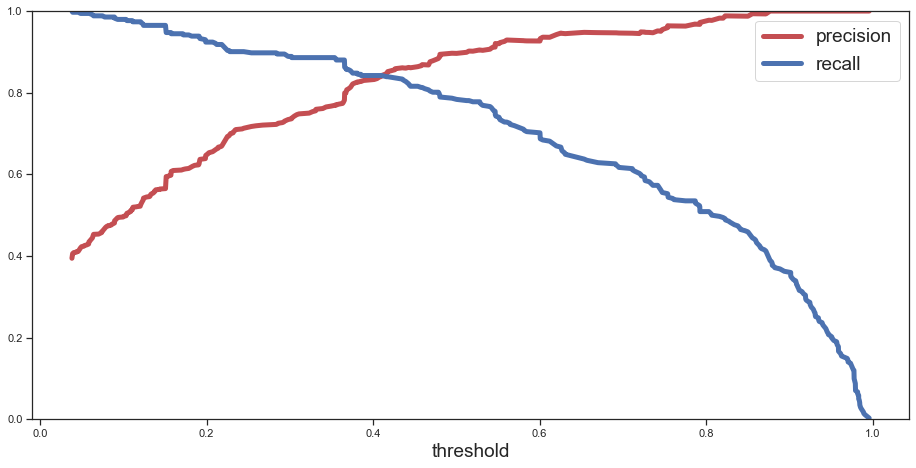

In [71]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

Above we can clearly see that the recall is falling of rapidly at a precision of around 85%. Because of that you may want to select the precision/recall tradeoff before that — maybe at around 75 %.
You are now able to choose a threshold, that gives you the best precision/recall tradeoff for your current machine learning problem. If you want for example a precision of 80%, we can easily look at the plots and see that you would need a threshold of around 0.4. Then you could train a model with exactly that threshold and would get the desired accuracy.

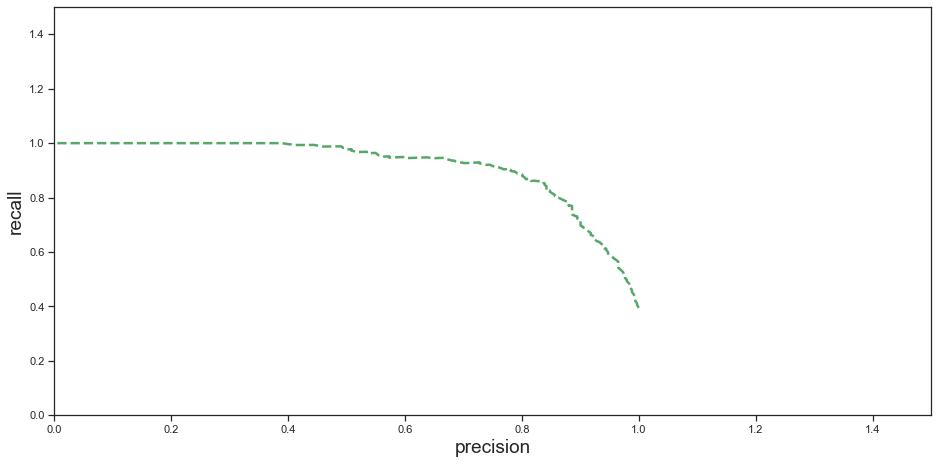

In [72]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(precision, recall)
plt.show()

# ROC AUC Curve

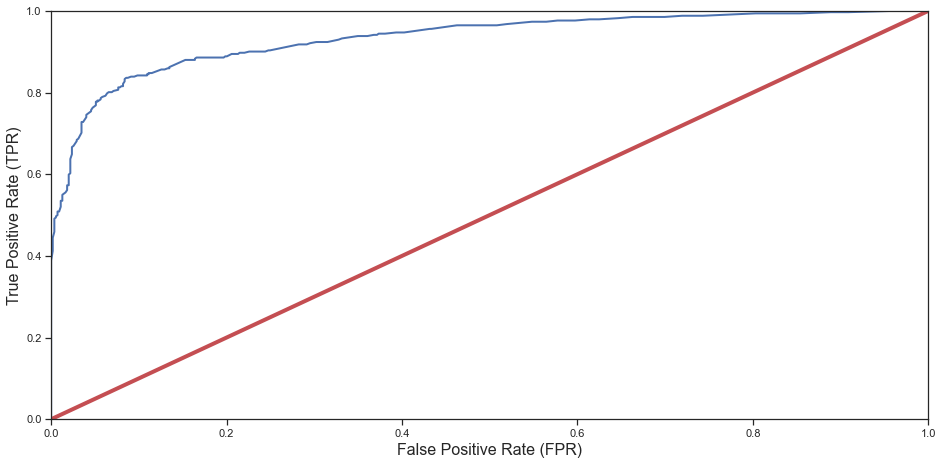

In [73]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

This curve plots the true positive rate (also called recall) against the false positive rate (ratio of incorrectly classified negative instances), instead of plotting the precision versus the recall.The red line in the middel represents a purely random classifier (e.g a coin flip) and therefore your classifier should be as far away from it as possible. Our Random Forest model seems to do a good job.
Of course we also have a tradeoff here, because the classifier produces more false positives, the higher the true positive rate is.

ROC AUC Score

In [74]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.9331107063347499


# Summary

Starting with the data exploration where we got a feeling for the dataset, checked about missing data and learned which features are important. During this process we used seaborn and matplotlib to do the visualizations. During the data preprocessing part, we computed missing values, converted features into numeric ones, grouped values into categories and created a few new features. Afterwards we started training 8 different machine learning models, picked one of them (random forest) and applied cross validation on it. Then we discussed how random forest works, took a look at the importance it assigns to the different features and tuned it’s performace through optimizing it’s hyperparameter values. Lastly, we looked at it’s confusion matrix and computed the models precision, recall and f-score.